# Solución hidrostática de una estrella formada por un gas ideal de $n$, $p$ y $e$ degenerados

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import CubicSpline, interp1d

## Ecuacion de estado del gas

### Expresiones

Similar al gas degenerado de neutrones, este gas ideal de $n$, $p$ y $e$ degenerados corresponde a la suma de las cantidades obtenidas para cada especie, dado que no interactúan. Así, utilizando los parámetro $x_i = \frac{p_F^i}{m_i c}$, se tiene para la presión, densidad de energía y densidad de número de partículas:

$$ \hat P = \frac{1}{P_0} (A_e f(x_e) + A_p f(x_p) + A_n f(x_n)), $$
$$ \hat \rho = \frac{3}{\rho_0} (A_e g(x_e) + A_p g(x_p) + A_n g(x_n))$$
$$ n = \frac{B_e}{m_e} x_e^3 + \frac{B_p}{m_p} x_p^3 + \frac{B_n}{m_n} x_n^3 \Rightarrow \rho_m = B_e x_e^3 + B_p x_p^3 + B_n x_n^3$$

donde

$$ f(x) = x\sqrt{x^2+1}(2x^2-3) + 3 ln(x+\sqrt{x^2+1}), $$
$$ g(x) = x\sqrt{x^2+1}(2x^2+1) + ln(x+\sqrt{x^2+1}),$$

con

$$ A_i = \frac{\pi m_i^4 c^5}{3h^3},$$
$$ B_i = \frac{8 \pi m_i^4 c^3}{3h^3} = \frac{8}{c^2}A_i.$$

Para resolver este sistema, se asume neutralidad global de la estrella, es decir, empleando la relación $n_i = \frac{8\pi}{3 h^3} (p_F^i)^3$, se tiene:

$$ n_e = n_p \Rightarrow m_e x_e = m_p x_p,$$

así como equilibrio frente al decaimiento $\beta$ inverso, considerando que el potencial químico en el caso completamente degenerado es la energía de fermi $\mu_i=E_F^i = m_i c^2 \left[ 1+ \left(\frac{p_F^i}{mc}\right)^2 \right]^{1/2}$:

$$ \mu_e + \mu_p = \mu_n \Rightarrow m_e(1+x_e^2)^{1/2} + m_p(1+x_p^2)^{1/2} = m_n(1+x_n^2)^{1/2}.$$

De este modo se tienen las siguientes relaciones que permiten resolver con el parametro $x_e$:

$$ x_p = \frac{m_e}{m_p} x_e,$$
$$ x_n = \frac{1}{m_n} \left[ \left( m_e(1+x_e^2)^{1/2} + \left(m_p^2+m_e^2 x_e^2\right)^{1/2} \right)^2 -m_n^2 \right]^{1/2}.$$

### Interpolación de las ecuaciones paramétricas

xmax = 4764.796245487424
rho0 = 3.698660188929993e+38


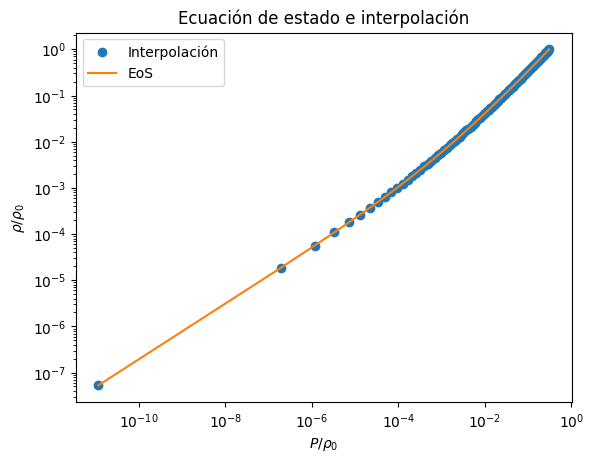

In [18]:
# Definimos constantes
pi = np.pi
m_n = 1.67e-27 # Masa del neutrón en kg
m_p = 1.67e-27 # Masa del protón en kg
m_e = 9.11e-31 # Masa del electrón en kg
c = 3e8 # Velocidad de la luz en m/s
h = 6.63e-34 # Constante de Planck en Js
G = 6.67e-11 # Constante de gravitación universal en m^3/kg/s^2

def A(m):
    return pi*m**4*c**5/(3*h**3) # Constante para cada especie
def B(m):
    return 8*pi*m**4*c**3/(3*h**3) # Constante para cada especie

# Definimos las funciones f y g
def f(x):
    return x*np.sqrt(1+x**2)*(2*x**2-3)+3*np.log(x+np.sqrt(1+x**2))
def g(x):
    return x*np.sqrt(1+x**2)*(2*x**2+1)+np.log(x+np.sqrt(1+x**2))

# Definimos las relaciones entre los parametros x de las especies, para quedar con x_e
def x_p(x):
    return m_e/m_p*x
def x_n(x):
    return np.sqrt( (m_p/m_n)**2*( (m_e/m_p) * np.sqrt(1 + x**2) + np.sqrt( 1.0 + (m_e/m_p)**2*x**2) )**2 - 1 ) 

# Definimos las funciones de presión, densidad de energía adimensionales y densidad de masa
def pressure(x, P0):
    return (A(m_e)*f(x)+A(m_p)*f(x_p(x))+A(m_n)*f(x_n(x)))/P0
def density(x, rho0):
    Ee = ( c**2*B(m_e)*x**3 + A(m_e)*(8*x**3*(np.sqrt(1+x**2)-1)-f(x)) )
    xp = x_p(x)
    Ep =  ( c**2*B(m_p)*xp**3 + A(m_p)*(8*xp**3*(np.sqrt(1+xp**2)-1)-f(xp)) )
    xn = x_n(x)
    En =  ( c**2*B(m_n)*xn**3 + A(m_n)*(8*xn**3*(np.sqrt(1+xn**2)-1)-f(xn)) )
    return (Ee+Ep+En)/rho0  
    #return 3*(A(m_e)*g(x)+A(m_p)*g(x_p(x))+A(m_n)*g(x_n(x)))/rho0

def density_mass(x):
    return B(m_e)*x**3+B(m_p)*x_p(x)**3+B(m_n)*x_n(x)**3

# Definimos la interpolacion para obtener rho = rho(P) (adimensional, P0 = rho0)
def EoS(x, rho0):
    return CubicSpline(pressure(x, rho0), density(x, rho0))

# Para hallar el rango de parametros a utilizar, invertimos la función de densidad de masa
# mediante una interpolación, y hallamos el valor xmax para el que la densidad es 10^17 g/cm^3
xlimit = 10000
density_mass_inv = CubicSpline(density_mass(np.linspace(0, xlimit, 3000)), np.linspace(0, xlimit, 3000), extrapolate=False) # x_e = x_e(rho_m)
xmax = density_mass_inv(1e18 * 1e3) # Pasamos de kg/m^3 a g/cm^3
print(f'xmax = {xmax}')

# Ejemplo de ecuación de estado para
rho0 = density(xmax, 1) # Densidad de energía adimensional en el centro asociada a 1e17 g/cm^3
print(f'rho0 = {rho0}')
x = np.linspace(0, xmax, 100)
rho_P = EoS(x, rho0)

plt.figure()
plt.loglog(pressure(x, rho0), rho_P(pressure(x, rho0)), "o", label='Interpolación')
plt.loglog(pressure(x, rho0), density(x, rho0), label='EoS')
plt.xlabel(r'$P/\rho_0$')
plt.ylabel(r'$\rho/\rho_0$')
plt.title('Ecuación de estado e interpolación')
plt.legend()
plt.show()

## Solución de las ecuaciones hidrostáticas

### Definición de los sistemas, funciones e integrador

In [19]:
# Definimos una función para convertir las cantidades adimensionales a cantidades físicas
# la adimensionalización es identica en Newton y en GR
def adimensional_to_fisico(sol_fin, P_central, r_fin, rho0):
    P, m, phi, rho = sol_fin
    
    # Obtenemos las constantes de adimensionalización
    P0 = rho0
    R = np.sqrt(c**4/(4*pi*G*rho0))
    M = 4*pi*R**3*rho0/c**2

    # Convertimos las cantidades adimensionales a cantidades físicas
    P_fisico = P0*P_central
    m_fisico = M*m
    phi_fisico = phi
    rho_fisico = rho0
    r_fisico = R*r_fin

    # P y rho finales
    # P_final = P0*P
    # rho_final = rho0*rho

    return [r_fisico, m_fisico, rho_fisico, P_fisico, phi_fisico]

# Definimos el sistema de ecuaciones newtonianas
def newtonianas(sol, r, rho_P):
    # Tomamos las variables
    P, m, phi = sol # Presion, masa y potencial adimensionales

    # Usamos la ecuación de estado para la densidad de energía
    rho = rho_P(P) # Densidad de energia adimensional

    # Definimos las derivadas
    dm_dr = r**2 * rho
    dP_dr = -m*rho/r**2
    dphi_dr = m/r**2

    # Devolvemos las derivadas
    return [dP_dr, dm_dr, dphi_dr]

# Definimos el sistema de ecuaciones GR
def relativistas(sol, r, rho_P):
    # Tomamos las variables
    P, m, phi = sol # Presion, masa y potencial adimensionales

    # Usamos la ecuación de estado para la densidad de energía
    rho = rho_P(P) # Densidad de energia adimensional

    # Definimos las derivadas
    dm_dr = r**2 * rho
    dP_dr = -m*rho/r**2*(1+P/rho)*(1+r**3*P/m)/(1-2*m/r)
    dphi_dr = -dP_dr/(rho + P)

    # Devolvemos las derivadas
    return [dP_dr, dm_dr, dphi_dr]

# Definimos la función que integre y recupere las cantidades fisicas para un valor de rho0 y un sistema de ecuaciones dado
def integrador(rf, dr, rho0_masa, sistema, sol_completa = False):
    # Malla de integración para ambos sistemas
    N = int(rf/dr) # Número de puntos
    r = np.linspace(dr, rf, N) # Puntos de integración

    # Realizamos la interpolacion de la relación rho = rho(P)
    x = np.linspace(0, xmax, 500)
    rho0 = density(density_mass_inv(rho0_masa * 1e3), 1) # Densidad central de energía kg/m/s^2
    rho_P = EoS(x, rho0)
    P_central = CubicSpline(density(x, rho0), pressure(x, rho0))(1) # Presion obtenida de la ecuacion de estado para rho=1

    # Definimos las condiciones iniciales en r = dr (para evitar la singularidad en r = 0)
    # estas son cantidades adimensionales, así que rho(0) = 1 y m(0) = 0
    rhoc = 1.0
    m0 = rhoc*dr**3/3 # m = 0 + 0r + 0r^2/2 + 2rho(0)r^3/6 ...
    
    if sistema == 'newtoniano':
        ecuaciones = newtonianas
        P0 = P_central- rhoc * dr**2 / 6.0
        phi0 = 1 + rhoc**2*dr**2/6
    elif sistema == 'relativista':
        ecuaciones = relativistas
        P0 = P_central- ( 3.0*P_central**2 + 4.0*P_central*rhoc + rhoc**2)*dr**2/6.0
        phi0 = 1 + ( rhoc/3.0 + P_central ) * dr**2 / 2.0

    # Resolvemos el sistema de ecuaciones
    sol = odeint(ecuaciones, [P0, m0, phi0], r, args=(rho_P,)).T

    # Obtenemos la densidad a partir de las presiones
    P, m, phi = sol
    rho = rho_P(P)

    # Buscamos el radio donde la densidad es cero
    lim = len(r)
    # la condicion debe ser con P, no siempre cuando P=0, rho=0
    for i in range(len(P)):
        if P[i] <= 0:
            lim = i-1
            break
    # print("Radio de la estrella: ", r[lim], " en el paso ", lim, " de ", N)

    # Obtenemos las cantidades finales
    sol_fin = [P[lim], m[lim], phi[lim], rho[lim]]

    if sol_completa:
        return adimensional_to_fisico(sol_fin, P_central, r[lim], rho0), np.append(sol[:, :lim], [rho[:lim]], axis=0), r[:lim]
    else:
        # Convertimos las cantidades adimensionales a cantidades físicas
        return adimensional_to_fisico(sol_fin, P_central, r[lim], rho0)

# Malla de integración para ambos sistemas
rf = 50 # Radio adimensional final
dr = 1e-3 # Paso de integración
N = int(rf/dr) # Número de puntos
r = np.linspace(dr, rf, N) # Puntos de integración

### Relación Masa Radio y Masa Densidad Central

In [20]:
# Definimos el rango de densidades de masa para el cual queremos integrar
rhos = np.linspace(14, 18, 50)
rhos = np.power(10, rhos)

# Integramos para cada densidad de masa
masas_N  = np.array([])
radios_N = np.array([])
masas_R  = np.array([])
radios_R = np.array([])

for rho in rhos:
    sol_N    = integrador(rf, dr, rho, 'newtoniano')
    sol_R    = integrador(rf, dr, rho, 'relativista')
    masas_N  = np.append(masas_N, sol_N[1])
    radios_N = np.append(radios_N, sol_N[0])
    masas_R  = np.append(masas_R, sol_R[1])
    radios_R = np.append(radios_R, sol_R[0])

0.7012555636291645


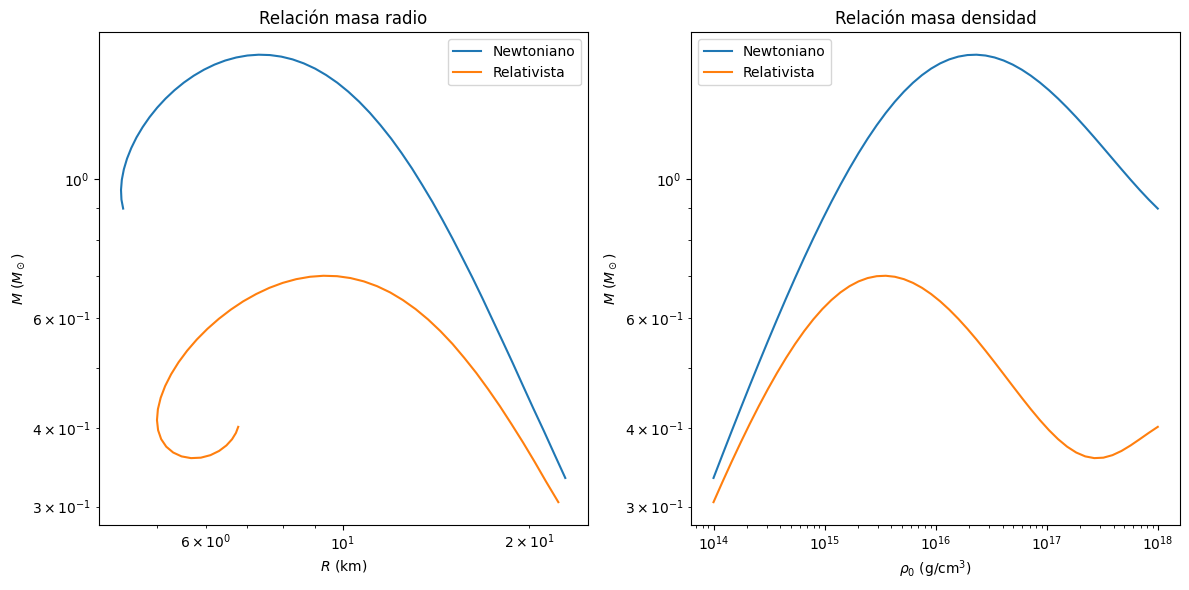

In [21]:
# Graficamos las relaciones masa radio y masa densidad en masas solares
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].loglog(radios_N/1e3, masas_N/2e30, label='Newtoniano')
ax[0].loglog(radios_R/1e3, masas_R/2e30, label='Relativista')
ax[0].set_xlabel(r'$R$ (km)')
ax[0].set_ylabel(r'$M$ ($M_\odot$)')
ax[0].set_title(r'Relación masa radio')
ax[0].legend()

ax[1].loglog(rhos, masas_N/2e30, label='Newtoniano')
ax[1].loglog(rhos, masas_R/2e30, label='Relativista')
ax[1].set_xlabel(r'$\rho_0$ (g/cm$^3$)')
ax[1].set_ylabel(r'$M$ ($M_\odot$)')
ax[1].set_title(r'Relación masa densidad')
ax[1].legend()

print(masas_R.max()/2e30)

plt.tight_layout()
plt.show()

### Sistema GR con la masa máxima

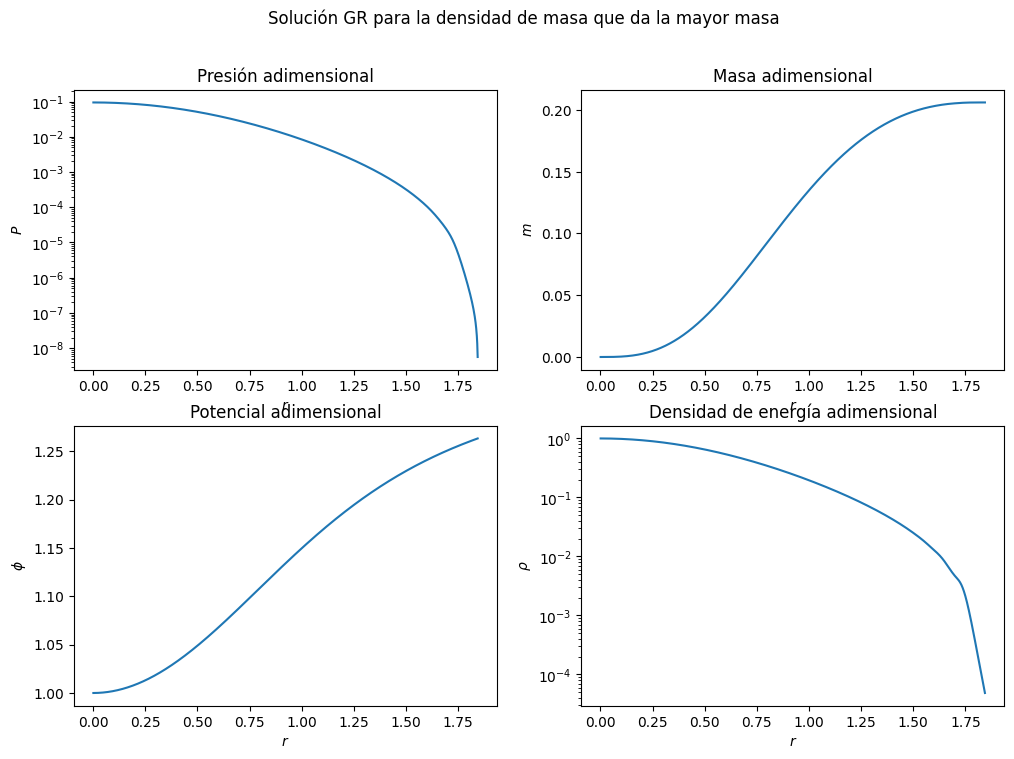

In [23]:
# Integramos para la densidad de masa que da la mayor masa
sol_final, sol_masa_max_R, r = integrador(rf, dr, rhos[np.argmax(masas_R)], 'relativista', sol_completa=True)

# Obtenemos la densidad a partir de las presiones
P_R, m_R, phi_R, rho_R = sol_masa_max_R

# Graficamos las soluciones
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax[0, 0].semilogy(r, P_R, label=r'$P$')
ax[0, 0].set_xlabel(r'$r$')
ax[0, 0].set_ylabel(r'$P$')
ax[0, 0].set_title(r'Presión adimensional')

ax[0, 1].plot(r, m_R, label=r'$m$')
ax[0, 1].set_xlabel(r'$r$')
ax[0, 1].set_ylabel(r'$m$')
ax[0, 1].set_title(r'Masa adimensional')

ax[1, 0].plot(r, phi_R, label=r'$\phi$')
ax[1, 0].set_xlabel(r'$r$')
ax[1, 0].set_ylabel(r'$\phi$')
ax[1, 0].set_title(r'Potencial adimensional')

ax[1, 1].semilogy(r, rho_R, label=r'$\rho$')
ax[1, 1].set_xlabel(r'$r$')
ax[1, 1].set_ylabel(r'$\rho$')
ax[1, 1].set_title(r'Densidad de energía adimensional')

# plt.tight_layout()
plt.suptitle('Solución GR para la densidad de masa que da la mayor masa')
plt.show()